# Exploratory Data Analysis

## Dataset Load
Here's the paths to the dataset's zip file and to the directory you want to extract the files:

In [1]:
# change path according to your local path
dset_zip_path = "D:\\_coding\\_wd\\_python\\uni\\Behavioral-Context-Recognition\\dataset\\" \
                "ExtraSensory.per_uuid_features_labels.zip"
dset_final_path = "D:\\_coding\\_wd\\_python\\uni\\Behavioral-Context-Recognition\\dataset\\unzipped_dataset"

From the main dataset's zip file <code>dset_zip_path</code>, we extract the inner gz files
(where 1 gz file contains measurements relative to 1 subject). The gz file are extracted to the directory
<code>dset_final_path</code>.

In [2]:
from zipfile import ZipFile

with ZipFile(dset_zip_path, 'r') as zipObject:
   listOfFileNames = zipObject.namelist()
   for fileName in listOfFileNames:
      zipObject.extract(fileName, dset_final_path)
   print('All the files are extracted')


All the files are extracted


Now we get the measurements' data from all files into 1 single DataFrame. Since data come from several gz files
(where each file is related to a single subject), for all measurement time stamp, we add the id of the relative subject
(by simply adding the name of the file).

In [3]:
import os
import gzip
import pandas as pd

df_list=[]
for gzFile in os.listdir(dset_final_path):
   path_gz = dset_final_path + "\\" + gzFile
   with gzip.open(path_gz) as f:
      df = pd.read_csv(f, header=0)
      df.insert(0,'uuid',gzFile[:-23])
      df_list.append(df)

df_dset = pd.concat(df_list, axis=0, ignore_index=True)
df_dset.head()

,uuid,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,00EABED2-271D-49D8-B599-1D4A09240601,1444079161,0.996815,0.003529,-0.002786,0.006496,0.995203,0.996825,0.998502,1.748756,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
1,00EABED2-271D-49D8-B599-1D4A09240601,1444079221,0.996864,0.004172,-0.003110,0.007050,0.994957,0.996981,0.998766,1.935573,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
2,00EABED2-271D-49D8-B599-1D4A09240601,1444079281,0.996825,0.003667,0.003094,0.006076,0.994797,0.996614,0.998704,2.031780,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
3,00EABED2-271D-49D8-B599-1D4A09240601,1444079341,0.996874,0.003541,0.000626,0.006059,0.995050,0.996907,0.998690,1.865318,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
4,00EABED2-271D-49D8-B599-1D4A09240601,1444079431,0.997371,0.037653,0.043389,0.102332,0.995548,0.996860,0.998205,0.460806,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2


Looking at the head of the DataFrame, we see that we have a total
of 279 columns: 278 from the csv files and the first one
(<code>uuid</code>) which we added for linking the single time stamp
to the relative subject id.

Now let's get a description of the <code>uuid</code> column to assess that all the subjects are added to the dataframe.

In [4]:
df_dset['uuid'].describe()

count                                   377346
unique                                      60
top       78A91A4E-4A51-4065-BDA7-94755F0BB3BB
freq                                     11996
Name: uuid, dtype: object

There are a total of 60 <code>unique</code> items in the <code>uuid</code> column so it's safe to say that all subjects'
 data have been correctly retrieved.

## Variables exploration
The general description of the dataset is accessible at the link
http://extrasensory.ucsd.edu/data/primary_data_files/README.txt.
The dataset contains data from different sensors (phone accelerometer, phone gyroscope, phone magnetometer,
watch accelerometer, watch compass, etc.) and for each of these sensors several measurements are collected
(mean values, std, etc.). In short, the number of different features and labels are:

In [5]:
cols = [x for x in df_dset.columns if "label" in x]
print("Number of labels = ", df_dset.loc[:, cols].shape[1])

cols = [x for x in df_dset.columns if "label" not in x]
print("Number of features = ", df_dset.loc[:, cols].shape[1]-2) # minus uuid and timestamp columns

Number of labels =  52
Number of features =  225


In the following sections we start by taking into consideration a single variable to find out the time series' trends
for each variable and the correlation between the single variable and the labels.

### Watch Acceleration
According to the dataset description at the link http://extrasensory.ucsd.edu/#description the data from the watch
accelerometer are collected at a frequency of 25Hz for ~20sec. Meaning that the features for watch acceleration
(<code>watch_acceleration:magnitude_stats:mean</code>, <code>watch_acceleration:magnitude_stats:std</code>, etc.)
for each sample in the dataset is refers to data collected in a 20s window.

In the following code let's consider data related to a single (randomly chosen) user:

In [6]:
uuid = '1155FF54-63D3-4AB2-9863-8385D0BD0A13'
user_data = df_dset.loc[df_dset['uuid']==uuid]
user_data = user_data.copy()
user_data.reset_index(inplace=True,drop=True)
print(user_data.shape)
user_data.head()

(2685, 279)


,uuid,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1155FF54-63D3-4AB2-9863-8385D0BD0A13,1464129912,1.011438,0.012573,0.023013,0.041240,1.006184,1.010868,1.016028,0.935099,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
1,1155FF54-63D3-4AB2-9863-8385D0BD0A13,1464129950,1.011233,0.009356,-0.005622,0.016687,1.006338,1.010926,1.016657,1.732968,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
2,1155FF54-63D3-4AB2-9863-8385D0BD0A13,1464130031,1.013422,0.018068,-0.008593,0.039286,1.004077,1.012983,1.021926,1.464639,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
3,1155FF54-63D3-4AB2-9863-8385D0BD0A13,1464130109,1.014891,0.016400,0.021383,0.038825,1.005934,1.014670,1.023000,1.440043,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
4,1155FF54-63D3-4AB2-9863-8385D0BD0A13,1464130130,1.017487,0.022632,-0.012891,0.037226,1.006040,1.017587,1.028168,1.937362,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2


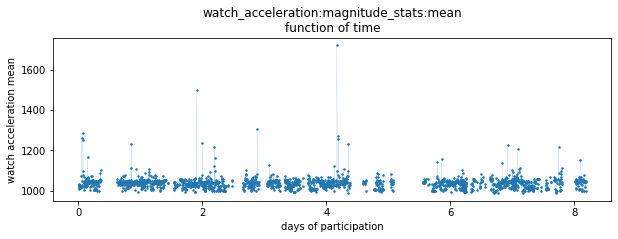

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,3),facecolor='white')
seconds_in_day = (60*60*24)
days_since_participation = (user_data["timestamp"] - user_data["timestamp"].iloc[0] ) / float(seconds_in_day)
plt.plot(days_since_participation,user_data["watch_acceleration:magnitude_stats:mean"],'.-',markersize=3,linewidth=0.1)
plt.xlabel('days of participation')
plt.ylabel('watch acceleration mean')
plt.title('watch_acceleration:magnitude_stats:mean\nfunction of time')
plt.show()

From the graph we can see that there are some missing values (<code>nan</code>) for this feature since we can see some
gaps.

The data refers to all 7 days of recordings, so for further investigations let's zoom in and consider data for a single
day (day one). Moreover, all <code>nan</code> values will be excluded:

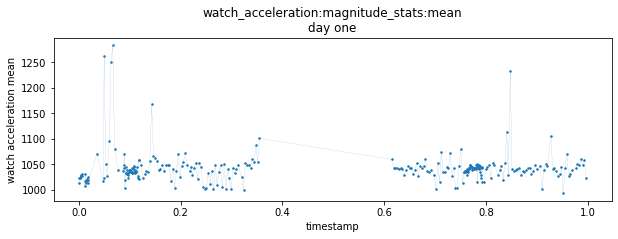

In [8]:
# drop all nan values
user_data_nonan = user_data.loc[:,["timestamp","watch_acceleration:magnitude_stats:mean"]].copy().dropna()

plt.figure(figsize=(10,3),facecolor='white')

# compute new normalized timestamp values
days_since_participation_nonan = (user_data_nonan["timestamp"] - user_data_nonan["timestamp"].iloc[0] ) / float(seconds_in_day)

# get all timestamps for day one
timestamp_day_one=days_since_participation_nonan[days_since_participation_nonan<=1]

# get all user data for day one
user_data_nonan_day_one = user_data_nonan.iloc[:timestamp_day_one.shape[0]]

plt.plot(timestamp_day_one,user_data_nonan_day_one["watch_acceleration:magnitude_stats:mean"],'.-',markersize=3,linewidth=0.1)
plt.xlabel('timestamp')
plt.ylabel('watch acceleration mean')
plt.title('watch_acceleration:magnitude_stats:mean\nday one')
plt.show()

The figure above refers to all watch acceleration magnitude mean values without taking into account the different labels.
So now we'll consider data linked to some different labels to better understand if watch acceleration could be useful to
distinguish between intuitively mutually exclusive labels.

In particular watch acceleration could be useful for distinguishing between WALKING vs SLEEPING behaviours since arms
tend to move more while walking while not at all while sleeping.
For the same reason WALKING vs SITTING could be another useful comparison to assess if arms moving pattern is really
that different in the two different actions or if the sitting behavior doesn't exclude the possibility of more arm movements.
For

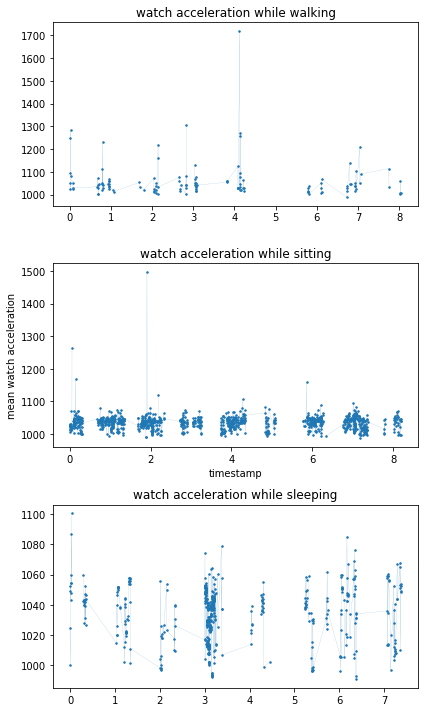

In [40]:
# from user_data get all rows with labels WALKING
user_data_walking = user_data.loc[user_data["label:FIX_walking"]==1].copy()
days_since_participation_walking = (user_data_walking["timestamp"] - user_data_walking["timestamp"].iloc[0] ) / float(seconds_in_day)

# from user_data get all rows with labels SITTING
user_data_sitting = user_data.loc[user_data["label:SITTING"]==1].copy()
days_since_participation_sitting = (user_data_sitting["timestamp"] - user_data_sitting["timestamp"].iloc[0] ) / float(seconds_in_day)

# from user_data get all rows with labels SLEEPING
user_data_sleeping = user_data.loc[user_data["label:SLEEPING"]==1].copy()
days_since_participation_sleeping = (user_data_sleeping["timestamp"] - user_data_sleeping["timestamp"].iloc[0] ) / float(seconds_in_day)

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_facecolor("white")
fig.set_figheight(10)
ax1.plot(days_since_participation_walking,
         user_data_walking["watch_acceleration:magnitude_stats:mean"], '.-',markersize=3,linewidth=0.1)
ax2.plot(days_since_participation_sitting,
         user_data_sitting["watch_acceleration:magnitude_stats:mean"], '.-',markersize=3,linewidth=0.1)
ax3.plot(days_since_participation_sleeping,
         user_data_sleeping["watch_acceleration:magnitude_stats:mean"], '.-',markersize=3,linewidth=0.1)

ax1.set_title("watch acceleration while walking")
ax2.set(xlabel="timestamp", ylabel="mean watch acceleration")
ax2.set_title("watch acceleration while sitting")
ax3.set_title("watch acceleration while sleeping")
fig.tight_layout()

The second graph (label SITTING) is denser than the first one (label WALKING). So we have (for this user) far more
samples for SITTING target variable than WALKING. Moreover, the data for SLEEPING tend to concentrate between two
consecutive days and that is consistent with the assumption that more sleeping hours are dedicated at nighttime.

The watch acceleration data for WALKING take values in a wider range [1000-1700] respect to the acceleration data for
SITTING and SLEEPING. Plus, the SITTING label data present more outliers than SLEEPING label data, demonstrating the fact
that arms tend to move more while sitting than sleeping and so watch acceleration could be a useful information for
distinguishing between the two behaviours.

The difference between mean values and outliers of the 3 different distributions of data could be more appreciated by looking at their boxplots:

Text(0.5, 1.0, 'watch acceleration while sleeping')

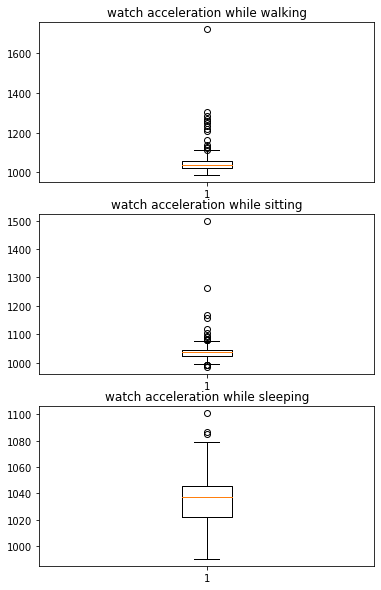

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_facecolor("white")
fig.set_figheight(10)

ax1.boxplot(user_data_walking["watch_acceleration:magnitude_stats:mean"].dropna())
ax2.boxplot(user_data_sitting["watch_acceleration:magnitude_stats:mean"].dropna())
ax3.boxplot(user_data_sleeping["watch_acceleration:magnitude_stats:mean"].dropna())

ax1.set_title("watch acceleration while walking")
ax2.set_title("watch acceleration while sitting")
ax3.set_title("watch acceleration while sleeping")

Looking at the boxplots it seems that the outliers of the WALKING data take values in a wider range [1400,1100] while
the outliers of SITTING data are more confined in the neighborhood of 1100. SLEEPING data outliers are considerably
fewer.

In conclusion, the plots have shown different patterns for the 3 different behaviours (WALKING, SITTING, SLEEPING), so
watch acceleration could be a useful mean to discriminate between the 3 different labels. Specifically, watch acceleration
present very different patterns for WALKING and SLEEPING, hence it could be a promising feature for a
WALKING vs SLEEPING classification problem.